In [ ]:
import scipy
from matplotlib import pyplot as plt
import cv2
import numpy as np
filepath1 = '/content/Dataset#1_2009 (1).mat'
filepath2 = '/content/Dataset#1_2015 (1).mat'
img_dict1 = scipy.io.loadmat(filepath1, mdict=None, appendmat=True)
img_dict2 = scipy.io.loadmat(filepath2, mdict=None, appendmat=True)

In [ ]:
def lin2rgb(img):
    # Convert the input image to double precision
    img = img.astype('float64') / np.max(img)

    # Apply the transformation to convert to RGB
    sRGB = np.zeros_like(img)
    sRGB[img <= 0.0031308] = 12.92 * img[img <= 0.0031308]
    sRGB[img > 0.0031308] = 1.055 * np.power(img[img > 0.0031308], 1 / 2.4) - 0.055

    # Scale the output image to the range [0, 255]
    sRGB = np.round(sRGB * 255).astype('uint8')

    return sRGB

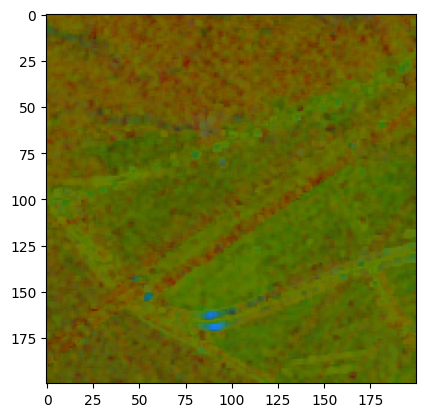

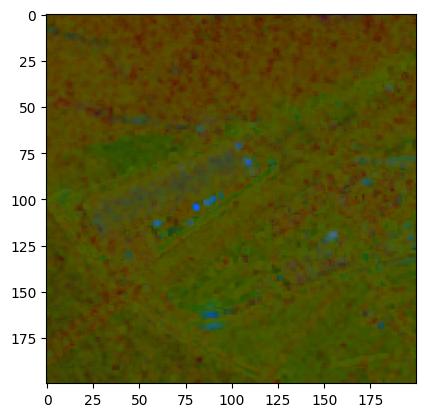

In [ ]:
## Part - 1: Image Smoothing with 3x3 Guassian Kernel
img_set1 = []
img_set2 = []
r_channel_1 = img_dict1['Data2009'][:,:,67]
g_channel_1 = img_dict1['Data2009'][:,:,21]
b_channel_1 = img_dict1['Data2009'][:,:,7]
rgb_image_1 = np.stack((r_channel_1, g_channel_1, b_channel_1), axis=2)
rgb_image_1 = rgb_image_1/ np.max(rgb_image_1)
rgb_image_1 = lin2rgb(rgb_image_1)
rbg_image_1 = cv2.GaussianBlur(rgb_image_1, (3, 3), 0)
plt.imshow(rgb_image_1)
plt.show()
r_channel_2 = img_dict2['Data2015'][:,:,67]
g_channel_2 = img_dict2['Data2015'][:,:,21]
b_channel_2 = img_dict2['Data2015'][:,:,7]
rgb_image_2 = np.stack((r_channel_2, g_channel_2, b_channel_2), axis=2)
rgb_image_2 = rgb_image_2 / np.max(rgb_image_2)
rgb_image_2 = lin2rgb(rgb_image_2)
rbg_image_2 = cv2.GaussianBlur(rgb_image_2, (3, 3), 0)
plt.imshow(rgb_image_2)
plt.show()

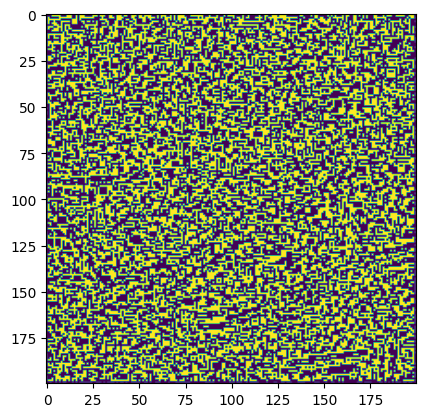

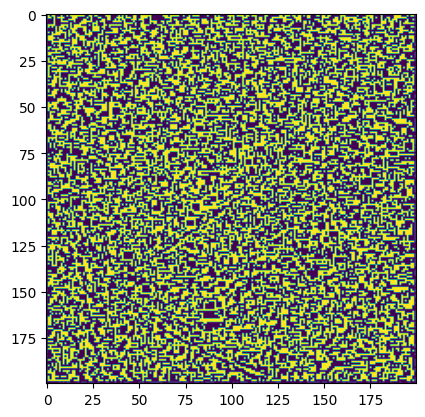

In [ ]:
## Part - 2: Feature Extraction- DLBP
def get_pixel(img, center, x, y, mean):

    new_value = 0
    try:
        # If local neighbourhood pixel
        # value is greater than or equal
        # to center pixel values then
        # set it to 1
        if img[x][y] >= mean and mean >= center:
            new_value = 1
        elif img[x][y] < mean and mean >= center:
            new_value = 1
        elif img[x][y] >= mean and mean < center:
            new_value = 0
        else:
            new_value = 0

    except:
        # Exception is required when
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass

    return new_value

# Function for calculating LBP
def dlbp_calculated_pixel(img, x, y, n):

    center = img[x][y]
    mean = 0
    count = 0
    for i in range(-n//2+1,n//2+1):
      for j in range(-n//2+1,n//2+1):
        if(x+i>=0 and y+j>=0 and x+i<height and y+j < width):
          mean += img[x+i][y+j]
          count = count + 1
    mean /= count
    val_ar = []
    power_val = []
    for i in range(-n//2+1,n//2+1):
      for j in range(-n//2+1,n//2+1):
        if((i==0 and j==0) or not(x+i>=0 and y+j>=0 and x+i<height and y+j < width)):
          continue
        val_ar.append(get_pixel(img, center, x+i, y+j, mean))
    for i in range(n*n-1):
      power_val.append(pow(2,i))

    val = 0

    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]

    return val

img_gray1 = cv2.cvtColor(rgb_image_1,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray1)
img_gray2 = cv2.cvtColor(rgb_image_2,cv2.COLOR_BGR2GRAY)
height, width = img_gray1.shape

  # We need to convert RGB image
  # into gray one because gray
  # image has one channel only.
  # img_gray1 = cv2.cvtColor(img_bgr1,
  #                       cv2.COLOR_BGR2GRAY)
  # img_gray2 = cv2.cvtColor(img_bgr2,
  #                       cv2.COLOR_BGR2GRAY)

  # Create a numpy array as
  # the same height and width
  # of RGB image
n = 3
img_lbp1 = np.zeros((height, width),
                   np.uint8)
img_lbp2 = np.zeros((height, width),
                   np.uint8)

for j in range(0, height):
  for k in range(0, width):
    img_lbp1[j, k] = dlbp_calculated_pixel(img_gray1, j, k, n)
    img_lbp2[j, k] = dlbp_calculated_pixel(img_gray2, j, k, n)
img_gray1 = img_lbp1
img_gray2 = img_lbp2
plt.imshow(img_gray1)
plt.show()
plt.imshow(img_gray2)
plt.show()

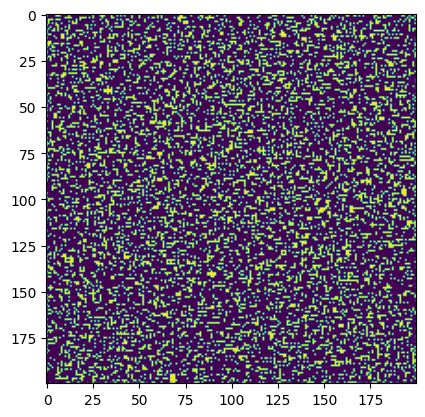

In [ ]:
fused_features = img_gray1 - img_gray2
# cv2.imshow("Fused Features", fused_features)
plt.imshow(fused_features)
plt.show()

[0, 1]
[[ 7  0]
 [ 0  0]
 [31  0]
 ...
 [31  0]
 [ 0  0]
 [ 7  7]]


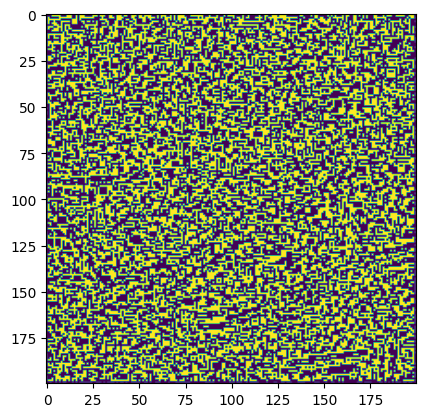

In [ ]:
def cfs(data, labels):
    # Calculate correlation coefficients
    corr_coef = np.corrcoef(data.T)

    # Calculate feature scores
    n_features = data.shape[1]
    feature_scores = np.zeros(n_features)
    for i in range(n_features):
        related_features = np.delete(np.arange(n_features), i)
        feature_scores[i] = np.sum(np.abs(corr_coef[i, related_features]))
    feature_scores /= np.sum(feature_scores)

    # Sort feature scores in descending order
    sorted_indices = np.argsort(feature_scores)[::-1]

    # Return indices of selected features
    selected_indices = []
    for i in sorted_indices:
        if labels[i] == 1:
            selected_indices.append(i)

    return selected_indices

# Calculate the difference image
img = np.column_stack((img_gray1.flatten(), img_gray2.flatten(), fused_features.flatten()))
labels = np.array([1, 1, 0])

  # Apply the Correlation Feature Subset Selection (CFS) algorithm
selected_indices = (cfs(img, labels))
print(selected_indices)
# Extract the selected features for each pixel
selected_features = img[:, selected_indices]
print(selected_features)
# Reshape the selected features into an image
selected_img = np.reshape(selected_features[:, 0], img_gray1.shape)
plt.imshow(selected_img)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def fcm(data, n_clusters, m=2, max_iter=100, error=1e-4):
    # Initialize membership matrix
    n_samples = data.shape[0]
    U = np.random.rand(n_clusters, n_samples)
    U = np.divide(U, np.sum(U, axis=0))

    # Iterate until convergence or max_iter is reached
    iteration = 0
    while iteration < max_iter:
        # Calculate centroids
        centroids = np.divide(np.dot(U**m, data), np.sum(U**m, axis=1, keepdims=True))

        # Calculate distances to centroids
        distances = pairwise_distances_argmin_min(data, centroids)

        # Update membership matrix
        new_U = np.zeros((n_clusters, n_samples))
        for i in range(n_clusters):
            new_U[i, :] = np.exp(-m * distances[0]**2 / distances[1][i]**2)
        U = np.divide(new_U, np.sum(new_U, axis=0))

        # Check for convergence
        if np.sum(np.abs(U - new_U)) < error:
            break

        iteration += 1

    # Calculate final centroids
    centroids = np.divide(np.dot(U**m, data), np.sum(U**m, axis=1, keepdims=True))

    # Return final membership matrix and centroids
    return U, centroids
# Define the number of clusters
k = 2
membership, centroids = fcm(selected_features, n_clusters=k, m=2, max_iter=100, error=1e-5)
labels = np.argmax(membership, axis=0)
change_map = np.reshape(labels, img_gray1.shape)

# Apply the Fuzzy C-Means (FCM) algorithm


# Classify the feature vector of each pixel into changed and unchanged classes


# Reshape the labels into an image

# Save the change map as an image
for elem in change_map:
  print(elem)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0
 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0
 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1
 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0]
[0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0
 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1

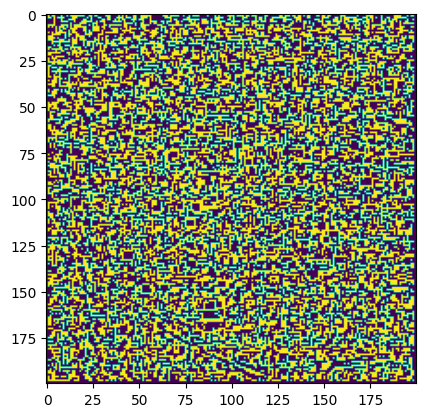

In [ ]:
plt.imshow(change_map)
plt.show()